In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import os

# Fetching data for BankNifty (^NSEBANK)
if os.path.exists("banknifty.csv"):
    banknifty = pd.read_csv("banknifty.csv", index_col=0)
else:
    banknifty = yf.Ticker("^NSEBANK")
    banknifty = banknifty.history(period="max")
    banknifty.to_csv("banknifty.csv")

# Convert the index to datetime
banknifty.index = pd.to_datetime(banknifty.index)

# Display the data
banknifty

del banknifty["Dividends"]
del banknifty["Stock Splits"]

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Step 1: Feature selection and scaling (LSTM works best with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(banknifty['Close'].values.reshape(-1, 1))

# Step 2: Create sequences (look-back)
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define the time step (number of previous days to consider for prediction)
time_step = 60  # This means the model will look at the last 60 days to predict the next day's price

# Create sequences and target variables
X, y = create_sequences(scaled_data, time_step)

# Reshape the data for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Step 3: Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 4: Build the LSTM model
model = Sequential()

# Add LSTM layer with 50 units and return sequences to stack another LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting

# Add another LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add Dense layer to get a single output (next day's price)
model.add(Dense(units=1))

# Step 5: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0114 - val_loss: 0.0021
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 9.4020e-04 - val_loss: 3.6211e-04
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 9.2519e-04 - val_loss: 5.9872e-04
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 7.4410e-04 - val_loss: 7.6783e-04
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 6.6654e-04 - val_loss: 0.0014
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 6.2803e-04 - val_loss: 3.7657e-04
Epoch 9/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 6.2742e-04 - val_loss: 5.1055e-04
Epoch 10/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 5.8235e-04 - val_loss: 3.4702e-04
Epoch 11/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 6.1975e-04 - val_loss: 9.8453e-04
Epoch 12/20

In [ ]:

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform([y_train])
y_test_actual = scaler.inverse_transform([y_test])


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


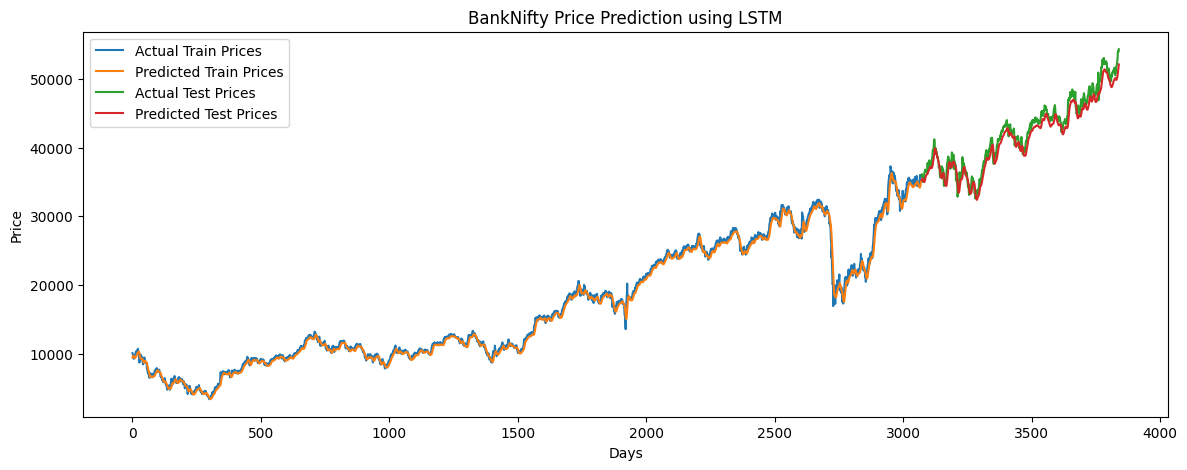

In [ ]:
import matplotlib.pyplot as plt

# Ploting the actual vs predicted prices
plt.figure(figsize=(14,5))

# Ploting training data
plt.plot(y_train_actual[0], label='Actual Train Prices')
plt.plot(train_predict, label='Predicted Train Prices')

# Ploting testing data
plt.plot(np.arange(len(y_train_actual[0]), len(y_train_actual[0]) + len(test_predict)), y_test_actual[0], label='Actual Test Prices')
plt.plot(np.arange(len(y_train_actual[0]), len(y_train_actual[0]) + len(test_predict)), test_predict, label='Predicted Test Prices')

plt.title('BankNifty Price Prediction using LSTM')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse_train = mean_squared_error(y_train_actual[0], train_predict)
mse_test = mean_squared_error(y_test_actual[0], test_predict)

r2_train = r2_score(y_train_actual[0], train_predict)
r2_test = r2_score(y_test_actual[0], test_predict)

print(f'Train Mean Squared Error: {mse_train}')
print(f'Test Mean Squared Error: {mse_test}')
print(f'Train R-squared: {r2_train}')
print(f'Test R-squared: {r2_test}')


Train Mean Squared Error: 373941.4701881334
Test Mean Squared Error: 1429119.6616050357
Train R-squared: 0.9950118663790722
Test R-squared: 0.9463274134536246
